## Hotel booking demand 分类与预测

[github地址](https://github.com/jlzz/jianlinzhen_datamining)

导入处理数据和绘图相关的包

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import seaborn as sns

plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False

读取数据并查看前几条数据

In [2]:
df = pd.read_csv("hotel_bookings.csv")
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### 1.基本情况：城市酒店和假日酒店预订需求和入住率比较；

城市酒店的预订信息比假日酒店的预订信息更多

In [3]:
df.hotel.value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

缺失值情况及缺失值的处理¶

In [4]:
df.isnull().sum() #每列的缺失值总行数

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
nan_replace = {"children": 0,"country": "Unknown", "agent": 0, "company": 0}
df_cln = df.fillna(nan_replace)
df_cln["meal"].replace("Undefined", "SC", inplace=True)
zero_guests = list(df_cln.loc[df_cln["adults"]
                   + df_cln["children"]
                   + df_cln["babies"]==0].index)
df_cln.drop(df_cln.index[zero_guests], inplace=True)
df = df_cln

In [6]:
df.isnull().sum() #每列的缺失值总行数

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

酒店预定需求以及入住率比较,可以看到就酒店预定来说城市酒店比假日酒店更受欢迎，人们更喜欢预定城市酒店

c:\users\jlz\appdata\local\conda\conda\envs\my_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='hotel', ylabel='count'>

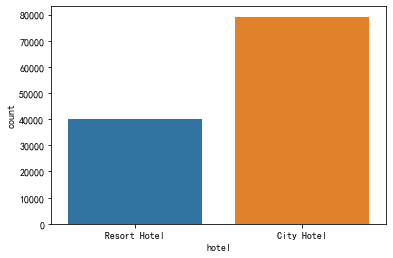

In [7]:
sns.countplot(df.hotel)

In [8]:
city_count_book = df.hotel.value_counts()['City Hotel']
resort_count_book = df.hotel.value_counts()['Resort Hotel']
resort_check_in = df[df['hotel'] == 'Resort Hotel'].is_canceled.value_counts()[0]
city_check_in = df[df['hotel'] == 'City Hotel'].is_canceled.value_counts()[0]

入住率=入住总数/预定总数,可以看出，假日酒店入住率远高于城市酒店

In [9]:
print('城市酒店入住率：', city_check_in/city_count_book)
print('假日酒店入住率：', resort_check_in/resort_count_book)

城市酒店入住率： 0.5821406465141543
假日酒店入住率： 0.7223262666367019


### 2.用户行为：提前预订时间、入住时长、预订间隔、餐食预订情况；

#### 提前预订时间

顾客平均提前预定时间为104天左右，预定最久的天数为737天，将近两年多。

大部分顾客都是当天预定当天入住。

In [10]:
time_list = list(df['lead_time'])
print('均值:', np.mean(time_list))
print("中位数：",np.median(time_list))
print("最小值：",min(time_list))
print("最大值：",max(time_list))
print("四分位数:",np.percentile(time_list, (25, 50, 75), interpolation='midpoint'))
counts = np.bincount(time_list)
print("众数：",np.argmax(counts))

均值: 104.10922741380756
中位数： 69.0
最小值： 0
最大值： 737
四分位数: [ 18.  69. 161.]
众数： 0


#### 入住时长
平均入住晚数为3晚左右，最大入住晚数为69天，两个多月，其中大部分顾客入住2晚。

In [11]:
df['stay_time'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
stay_list = list(df['stay_time'])
print('均值:', np.mean(stay_list))
print("中位数：",np.median(stay_list))
print("最小值：",min(stay_list))
print("最大值：",max(stay_list))
print("四分位数:",np.percentile(stay_list, (25, 50, 75), interpolation='midpoint'))
counts = np.bincount(stay_list)
print("众数：",np.argmax(counts))

均值: 3.4262477980035233
中位数： 3.0
最小值： 0
最大值： 69
四分位数: [2. 3. 4.]
众数： 2


#### 餐食预订情况
大多数人会在酒店中订餐，其中大部分人预定了BB这个套餐类型，很少人订FB这个套餐类型。当然不是所有人都会在酒店订餐，少部分人不需要订餐服务

c:\users\jlz\appdata\local\conda\conda\envs\my_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='meal', ylabel='count'>

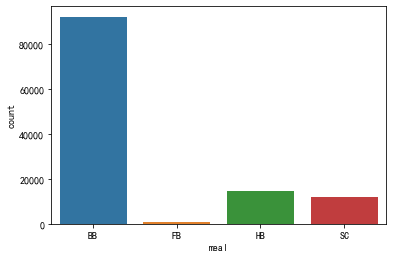

In [12]:
sns.countplot(df.meal)

### 3.一年中最佳预订酒店时间;

酒店入住情况

<AxesSubplot:xlabel='arrival_date_month,arrival_date_year'>

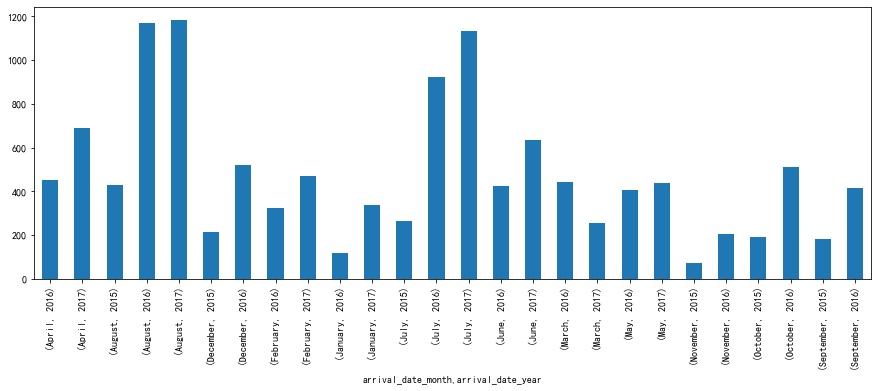

In [13]:
df.groupby(['arrival_date_month','arrival_date_year'])['children'].sum().plot.bar(figsize=(15,5))

最佳预定酒店的时间应为每年的1、2月和11、12月，这几个时间段的酒店的入住人数少且价格较低，是最佳的酒店预定入住时间。

### 4.利用Logistic预测酒店预订。

In [14]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
company                           0.083594
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
agent                             0.046770
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
stay_time                         0.018554
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

In [15]:
df.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: reservation_status, dtype: int64

用逻辑回归预测

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

features = num_features + cat_features
X = df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]


num_transformer = SimpleImputer(strategy="constant")

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
base_models = [("LR_model", LogisticRegression(random_state=42,n_jobs=-1))]
kfolds = 4
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

for name, model in base_models:
    
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
   
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

LR_model cross validation accuarcy score: 0.7947 +/- 0.0027 (std) min: 0.7915, max: 0.7984
